# Object Detection Demo 3: Connecting it to GIS via the ArcGIS API for Python
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import cv2

In [2]:
# Set our caption 
cap = cv2.VideoCapture(0)

## Env setup

In [3]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Helper code

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

This is a helper function that takes the detection graph output tensor (np arrays), stacks the classes and scores, and determines if the class for a person (1) is available within a certain score and within a certain amount of objects

In [11]:
def person_in_image(classes_arr, scores_arr, obj_thresh=5, score_thresh=0.5):
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    person_found_flag = False
    for ix in range(obj_thresh):
        if 1.00000000e+00 in stacked_arr[ix]:
            if stacked_arr[ix][1] >= score_thresh:
                person_found_flag = True
            
    return person_found_flag

# Establish Connection to GIS via ArcGIS API for Python

### Authenticate

In [12]:
import arcgis

In [13]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis"
}

gis_url = portals_dict["esrifederal_gis"]

if gis_url == portals_dict["esrifederal_gis"]:
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


### Retrieve the Object Detection Point Layer

<Item title:"Object_Detection_Point" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
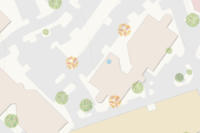

In [14]:
object_point_srvc = gis.content.search("Object_Detection_Point")[0]
object_point_srvc

In [15]:
# Convert our existing service into a pandas dataframe
object_point_lyr = object_point_srvc.layers[0]
obj_fset = object_point_lyr.query()  #querying without any conditions returns all the features
obj_df = obj_fset.df
obj_df.head()

,CellPhone_Found,Chair_Found,CreationDate,Creator,EditDate,Editor,GlobalID,OBJECTID,Person_Found,SHAPE
0,False,False,1505250771759,albe9057@esri.com_esrifederal,1505492234727,albe9057@esri.com_esrifederal,5653b059-c13d-4c64-b366-91fa980803e5,1,False,"{'x': -8599193.8441, 'y': 4711366.046400003}"


In [16]:
all_features = obj_fset.features
all_features

[{"geometry": {"x": -8599193.8441, "y": 4711366.046400003}, "attributes": {"OBJECTID": 1, "Person_Found": "False", "Chair_Found": "False", "CellPhone_Found": "False", "GlobalID": "5653b059-c13d-4c64-b366-91fa980803e5", "CreationDate": 1505250771759, "Creator": "albe9057@esri.com_esrifederal", "EditDate": 1505492234727, "Editor": "albe9057@esri.com_esrifederal"}}]

In [17]:
from copy import deepcopy

original_feature = all_features[0]
feature_to_be_updated = deepcopy(original_feature)
feature_to_be_updated

{"geometry": {"x": -8599193.8441, "y": 4711366.046400003}, "attributes": {"OBJECTID": 1, "Person_Found": "False", "Chair_Found": "False", "CellPhone_Found": "False", "GlobalID": "5653b059-c13d-4c64-b366-91fa980803e5", "CreationDate": 1505250771759, "Creator": "albe9057@esri.com_esrifederal", "EditDate": 1505492234727, "Editor": "albe9057@esri.com_esrifederal"}}

### Test of Manual Update

In [18]:
feature_to_be_updated.attributes['Person_Found']

'False'

In [19]:
features_for_update = []
feature_to_be_updated.attributes['Person_Found'] = "False"
features_for_update.append(feature_to_be_updated)

In [20]:
object_point_lyr.edit_features(updates=features_for_update)

{'addResults': [],
 'deleteResults': [],
 'updateResults': [{'globalId': '5653b059-c13d-4c64-b366-91fa980803e5',
   'objectId': 1,
   'success': True}]}

# Detection

In [21]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        while True:
            ret, image_np = cap.read()
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8, min_score_thresh=0.5)
            
            cv2.imshow('object detection', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break
                
            person_found = person_in_image(np.squeeze(classes).astype(np.int32), 
                                           np.squeeze(scores), 
                                           obj_thresh=2)
            
            features_for_update = []
            feature_to_be_updated.attributes['Person_Found'] = str(person_found)
            features_for_update.append(feature_to_be_updated)
            object_point_lyr.edit_features(updates=features_for_update)

#### To view the map containing the updated feature:

http://esrifederal.maps.arcgis.com/home/webmap/viewer.html?webmap=6cadd789f1ce44ab8271beed4ef76ebe